# Time series analysis using ARIMA+GARCH vs Recurrent-Neural-Nets

## Idea:

We use the standard techniques to forecast the "future" stock prices up to a "maturity time" (the maturity time is set by the option contract in principle). We first find the de-trended and de-seasoned data by applyig log and diff transfroms, and then by checking (auto-)correlation graphs (and adfuller test) to find the moving-average and autor-regression indices of ARIMA.<br>
The second approach to forecast stock prices, recurrent neural networks are used. Standard LSTM and GRU architectures can be used to find the best fitted setups.<br> 
After this, we will use GARCH to forecast future volatility of the data. These volatilities together with forecasted stock data to add uncertainties of these forecasts.<br>
We will separate the dataset into all data up to time "-T" (T = maturity time), and assume the data from -T until "now" as the part to be predicted.<br>

Collaborator: Dr. A. Sadeghi (https://github.com/amirhs1)

In [ ]:
import matplotlib.pyplot as plt #3.10.0
%matplotlib inline
import pandas as pd # 2.2.2
import numpy as np #1.26.4

# statsmodels version 0.14.4
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler # varsion 1.6.1
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import tensorflow as tf # version 2.18.0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RNN, GRU, Dense, BatchNormalization, Activation

import arch #7.2.0
from arch import arch_model

import yfinance as yf # 0.2.52
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime

import joblib #1.4.2

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

#from random import randrange
#import itertools

In [167]:
# download the data of AAPL stock from alpha_vantage.

api_key = 'YOUR_API_KEY'
ts = TimeSeries(key=api_key, output_format='pandas')
stock_data, meta_data = ts.get_daily(symbol='AAPL', outputsize='full')
stock_data = stock_data.iloc[:1000]
stock_data.to_csv("AAPL_raw.csv")

stock_data.head()


,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2025-02-18,244.15,245.1800,241.84,244.47,48822491.0
2025-02-14,241.25,245.5500,240.99,244.60,40896227.0
2025-02-13,236.91,242.3399,235.57,241.53,53614054.0
2025-02-12,231.20,236.9600,230.68,236.87,45243292.0
2025-02-11,228.20,235.2300,228.13,232.62,53718362.0


In [3]:
# Save data:
stock_data = pd.read_csv("AAPL_raw.csv")
stock_data['Close'] = stock_data['4. close']
stock_data.set_index('date',inplace = True)
stock_data.sort_index(ascending = True,inplace = True)
stock_data.head()

,1. open,2. high,3. low,4. close,5. volume,Close
date,,,,,,
2021-02-25,124.68,126.4585,120.54,120.99,144766924.0,120.99
2021-02-26,122.59,124.8500,121.20,121.26,163424672.0,121.26
2021-03-01,123.75,127.9300,122.79,127.79,116307892.0,127.79
2021-03-02,128.41,128.7200,125.01,125.12,102260945.0,125.12
2021-03-03,124.81,125.7100,121.84,122.06,112966340.0,122.06


## Analysis:

As is clear in the following graph, the prices change a lot by going from almost 100 to 250:

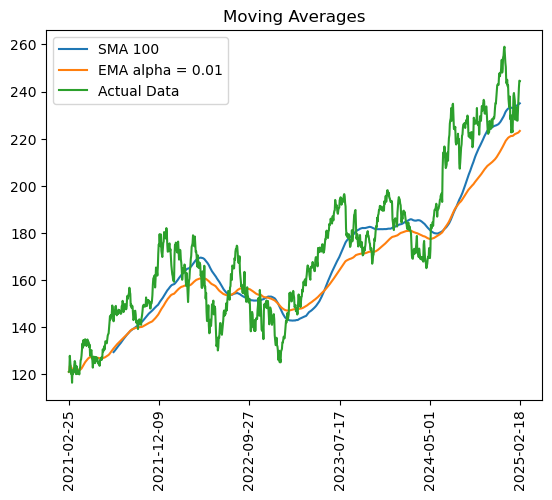

In [5]:
roll_close = stock_data.Close.rolling(window = 100)
Close_SMA = roll_close.mean()
alpha = 0.01
ewm_close = stock_data.Close.ewm(alpha = alpha)
Close_EMA = ewm_close.mean()


plt.plot(stock_data.index, Close_SMA, label = 'SMA 100')
plt.plot(stock_data.index, Close_EMA, label = 'EMA alpha = {}'.format(alpha))
plt.plot(stock_data.index, stock_data.Close, label = 'Actual Data')
plt.legend()
plt.xticks(ticks = [0,200,400,600,800,999], rotation = 90)
plt.title('Moving Averages')

plt.show()

Clearly, this timeseries have dominant trend and seasonality. We need to find a transfored timeseries that doesn't show any trend or seasonality to apply ARIMA to it.

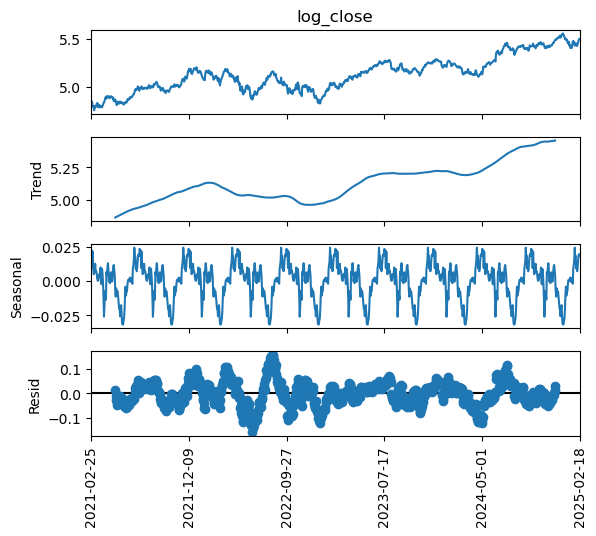

In [7]:
#Data Decomposition (additive):
stock_data['log_close'] = np.log(stock_data.Close)
stock_mul = seasonal_decompose(stock_data.log_close.dropna(), period = 100, model = 'additive')
stock_mul.plot()
plt.xticks(ticks = [0,200,400,600,800,999], rotation = 90)
plt.show()

It seems log.diff.diff transormed data doesn't show significant trend in it:

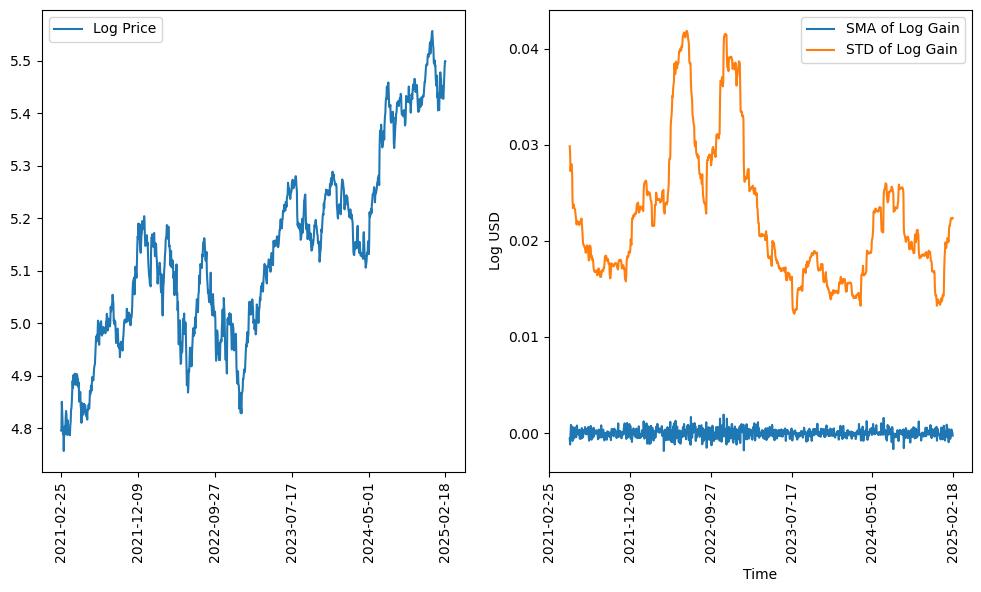

In [9]:
roll_log_close = stock_data.log_close.diff().diff().rolling(window = 50)
SMA_log_close = roll_log_close.mean()
std_log_close = roll_log_close.std()


plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(stock_data.index, stock_data.log_close, label = 'Log Price')
plt.legend()
plt.xticks(ticks = [0,200,400,600,800,999], rotation = 90)

plt.subplot(122)
plt.plot(stock_data.index, SMA_log_close, label = 'SMA of Log Gain')
plt.plot(stock_data.index, std_log_close, label = 'STD of Log Gain')
plt.xticks(ticks = [0,200,400,600,800,999], rotation = 90)

plt.xlabel('Time')
plt.ylabel('Log USD')
plt.legend()


plt.show()

However, the standard deviations shows clustering, which is not good... Let's check the trend and seasonality components of this transfored data:

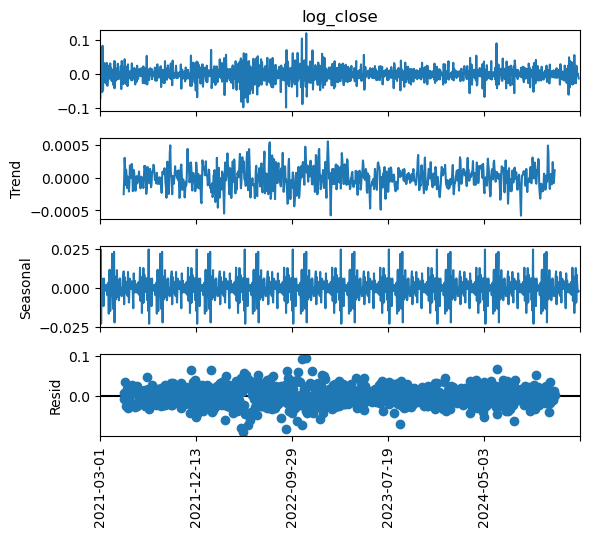

In [11]:
#Data Decomposition (additive):
stock_data['log_close'] = np.log(stock_data.Close)
stock_mul = seasonal_decompose(stock_data.log_close.diff().diff().dropna(), period = 100, model = 'additive')
stock_mul.plot()
plt.xticks(ticks = [0,200,400,600,800,999], rotation = 90)

plt.show()

As expected, the transformed data doesn't have a significant trend. But since STD is clustred, it's not good enough for using it in ARIMA forecasts. Let's try anyways. First we need to find p and q in ARIMA (based on the previous analysis, d = 2 when we use log transformed data):

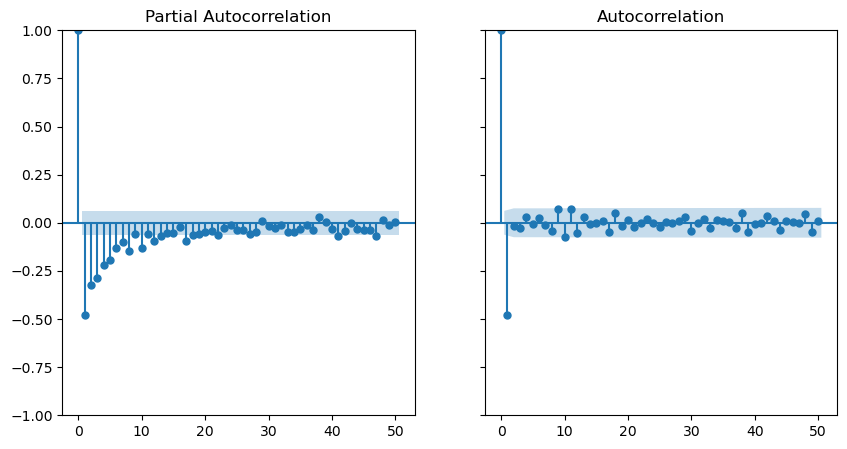

In [13]:
fig, axes = plt.subplots(1,2, figsize = (10,5), sharey=True)

tsaplots.plot_pacf(stock_data.log_close.diff().diff().dropna(), ax=axes[0], lags = 50)
tsaplots.plot_acf(stock_data.log_close.diff().diff().dropna(), ax=axes[1], lags = 50)

plt.show()

In [15]:
adfuller(stock_data.log_close.diff().diff().dropna(), maxlag = 100, autolag = 'AIC')

(-11.654697033990422,
 1.9984069370498074e-21,
 21,
 976,
 {'1%': -3.4370678095881804,
  '5%': -2.8645058608075264,
  '10%': -2.568349178354273},
 -4728.160102757696)

## ARIMA:

p = 22, and q = 2 (We assume maturity time T = 20):

In [17]:
T = 20 #maturity time in days
train , test= stock_data.iloc[:-T],  stock_data.iloc[-T:]

model = ARIMA(train.log_close.dropna().astype(float), order = (22,2,2) ) #order = (ar, diff, ma)
model_fit = model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              log_close   No. Observations:                  980
Model:                ARIMA(22, 2, 2)   Log Likelihood                2607.548
Date:                Wed, 19 Feb 2025   AIC                          -5165.096
Time:                        16:30:14   BIC                          -5042.958
Sample:                             0   HQIC                         -5118.625
                                - 980                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5713      0.893     -0.640      0.522      -2.322       1.179
ar.L2         -0.2775      0.176     -1.575      0.115      -0.623       0.068
ar.L3         -0.2761      0.209     -1.318      0.187      -0.687       0.134
ar.L4         -0.2111      0.194     -1.087      0.277      -0.592       0.170
ar.L5         -0.1876      0.158     -1.187      0.235      -0.497       0.122
ar.L6         -0.1568      0.153     -1.024      0.306      -0.457       0.143
ar.L7         -0.1728      0.135     -1.283      0.199      -0.437       0.091
ar.L8         -0.1982      0.143     -1.391      0.164      -0.478       0.081
ar.L9         -0.1362      0.150     -0.910      0.363      -0.430       0.157
ar.L10        -0.1769      0.111     -1.588      0.112      -0.395       0.041
ar.L11        -0.1284      0.142     -0.904      0.366      -0.407       0.150
ar.L12        -0.1454      0.104     -1.397      0.162      -0.349       0.059
ar.L13        -0.1281      0.123     -1.041      0.298      -0.369       0.113
ar.L14        -0.1255      0.096     -1.301      0.193      -0.315       0.064
ar.L15        -0.1277      0.105     -1.211      0.226      -0.334       0.079
ar.L16        -0.1088      0.101     -1.082      0.279      -0.306       0.088
ar.L17        -0.1289      0.087     -1.474      0.141      -0.300       0.042
ar.L18        -0.0598      0.102     -0.589      0.556      -0.259       0.139
ar.L19        -0.0471      0.064     -0.739      0.460      -0.172       0.078
ar.L20        -0.0501      0.058     -0.867      0.386      -0.163       0.063
ar.L21        -0.0499      0.054     -0.929      0.353      -0.155       0.055
ar.L22        -0.0406      0.038     -1.058      0.290      -0.116       0.035
ma.L1         -0.3905      0.893     -0.437      0.662      -2.140       1.359
ma.L2         -0.3337      0.758     -0.440      0.660      -1.819       1.151
sigma2         0.0003   1.06e-05     26.479      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               117.87
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The p-values of the coefficients and Kurtosis are large, which means the fitted ARIMA model is not a good one, as expected. Let's compare it with the actual data (to compare correctly we need the variance forecasts too, look at the final graph for the results).

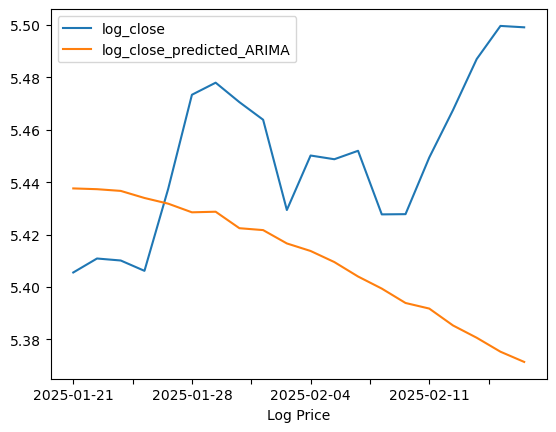

,log_close,log_close_predicted_ARIMA
date,,
2025-01-21,5.405556,5.437628
2025-01-22,5.410887,5.437333
2025-01-23,5.410127,5.436682
2025-01-24,5.406185,5.433980
2025-01-27,5.437470,5.431809


In [19]:

steps = T

forecasts = model_fit.forecast(steps = steps)
stock_forecast = stock_data[['log_close']].iloc[-T:].copy()
stock_forecast['log_close_predicted_ARIMA'] = forecasts.values

stock_forecast.plot()
plt.xlabel('Log Price')
plt.show()

stock_forecast.head()

## GARCH:

In [21]:
import datetime as dt
split_date = dt.datetime.strptime(stock_data[['log_close']].iloc[-T:-T+1].index[0], "%Y-%m-%d").date
model_garch = arch_model(stock_data.log_close.diff().diff().dropna().astype(float), mean = 'Zero', vol='garch', p=1, o=0, q=1)
model_garch_fit = model_garch.fit(last_obs=split_date)
forecasts = model_garch_fit.forecast(start = len(stock_data.iloc[:-T-2]), horizon = T).variance
model_garch_fit.summary()


Iteration:      1,   Func. Count:      5,   Neg. LLF: -2213.545079200696
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1588.0419097121523
Iteration:      3,   Func. Count:     18,   Neg. LLF: 536294182.7516536
Iteration:      4,   Func. Count:     25,   Neg. LLF: -2176.2294653904373
Iteration:      5,   Func. Count:     30,   Neg. LLF: -2176.416802954868
Iteration:      6,   Func. Count:     34,   Neg. LLF: -2390.404412603968
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2390.4044131393534
            Iterations: 10
            Function evaluations: 34
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:              log_close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                2390.40
Distribution:                  Normal   AIC:                          -4774.81
Method:            Maximum Likelihood   BIC:                          -4760.09
                                        No. Observations:                  998
Date:                Wed, Feb 19 2025   Df Residuals:                      998
Time:                        16:30:20   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.3469e-05  1.383e-05      3.143  1.670e-03 [1.636e-05,7.057e-05]
alpha[1]       0.1459  6.584e-02      2.215  2.674e-02   [1.681e-02,  0.275]
beta[1]        0.7793  7.987e-02      9.758  1.711e-22     [  0.623,  0.936]
============================================================================

Covariance estimator: robust
"""

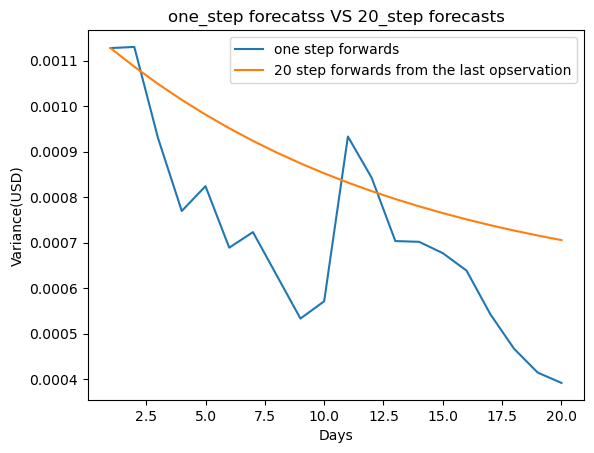

In [23]:
one_step_preds = forecasts.iloc[:,0]
T_step_preds= forecasts.iloc[0]
plt.plot(range(1, len(one_step_preds.index)+1), one_step_preds, label = "one step forwards")
plt.plot(range(1, len(one_step_preds.index)+1), T_step_preds, label = f"{T} step forwards from the last opservation")

plt.xlabel( 'Days')
plt.ylabel('Variance(USD)')
plt.title("one_step forecatss VS {}_step forecasts".format(T))
plt.legend()

plt.show()

In [25]:
# Save variances for later use
real_variance = pd.DataFrame(index = forecasts.index, columns = ['Variances'])
real_variance.to_csv('real_variances.csv')
#for i in range(len(forecasts)):
#    sigma_2_1 = 0.5 * sum(forecasts.iloc[:i+1,0])
#    sigma_2_2 = 0.5 * sum(forecasts.iloc[:i, 0])
#    var =  0.5 * sigma_2_1
#    real_variance.iloc[i,0] = var


## RNN:

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
{'loss': 0.008143170736730099, 'mse': 0.016286341473460197}


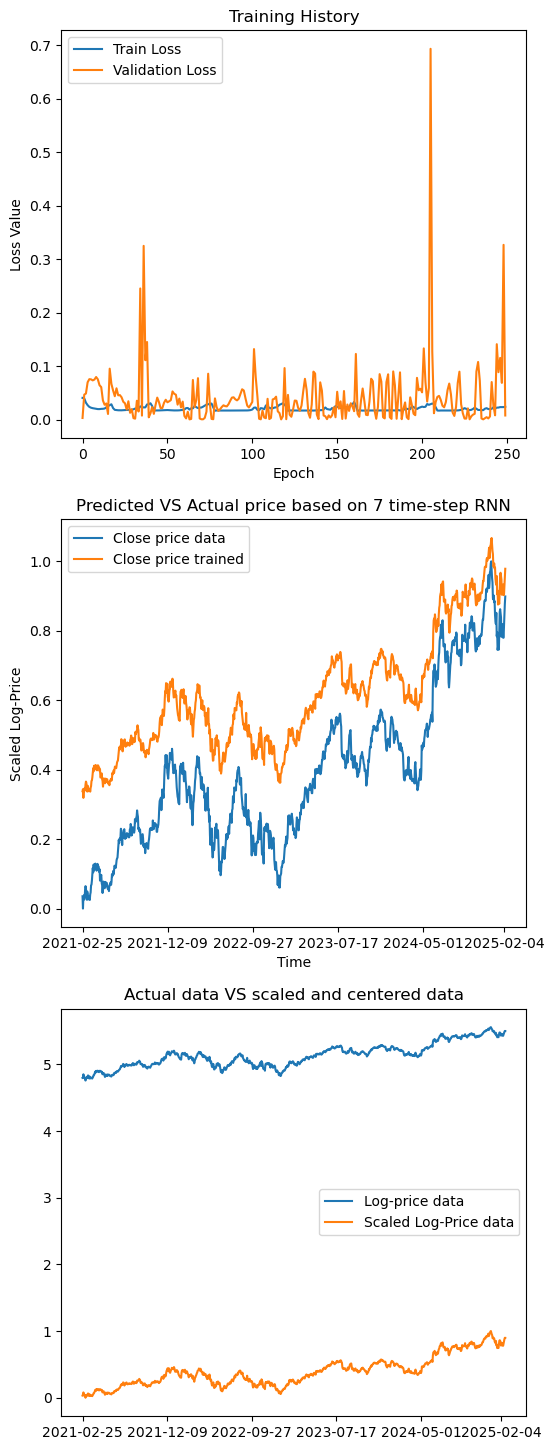

In [31]:
class Custom_RNN():
    def __init__(self,rnn_type,
                 num_rnn_layers,
                 seq_len,
                 num_features,
                 hidden_layer_shapes,
                 ls_activations = [],
                initializer = 'glorot_normal',
                 **kwargs):
        self.rnn_type = rnn_type
        self.n_layers = num_rnn_layers
        self.seq_len  = seq_len
        self.num_feat = num_features
        self.acts     = ls_activations
        self.inits    = initializer
        self.nodes    = hidden_layer_shapes


    def Model(self):
        if self.rnn_type == 'LSTM':
            model = Sequential([
                LSTM(units = self.nodes[0],
                     input_shape = (self.seq_len, self.num_feat),
                     kernel_initializer = self.inits,
                     return_sequences = True,
                    unroll=True),
                BatchNormalization(trainable=True, scale=True, center=True),
                Activation(self.acts[0])
            ])
            for i in range(1, self.n_layers):
                model.add(LSTM(units = self.nodes[i], kernel_initializer = self.inits,return_sequences = True))
                model.add(BatchNormalization(trainable=True, scale=True, center=True))
                model.add(Activation(self.acts[i]))
            model.add(Dense(units = 1))

        elif self.rnn_type == 'GRU':
            model = Sequential([
                GRU(units = self.nodes[0],
                     input_shape = (self.seq_len, self.num_feat),
                     kernel_initializer = self.inits,
                     return_sequences = True,
                   unroll=True),
                BatchNormalization(trainable=True, scale=True, center=True),
                Activation(self.acts[0])
            ])
            for i in range(1, self.n_layers):
                model.add(GRU(units = self.nodes[i], kernel_initializer = self.inits,return_sequences = True))
                model.add(BatchNormalization(trainable=True, scale=True, center=True))
                model.add(Activation(self.acts[i]))
            model.add(Dense(units = 1))

        return model


num_steps = 7
architecture = Custom_RNN(rnn_type = 'GRU',
                 num_rnn_layers = 1,
                 seq_len = num_steps - 1,
                 num_features = 1 ,  #  #target = close
                 initializer =  'glorot_normal',
                 ls_activations = [None],
                 hidden_layer_shapes = [35])
model_RNN = architecture.Model()
optimizer = tf.optimizers.Adam(learning_rate=1.5e-2, weight_decay=5e-4)
model_RNN.compile(optimizer=optimizer, loss='Huber', metrics=['mse'])

features = ['Close']
X0 = stock_data[features] # Stock time series
X0['log_price'] = X0['Close'].apply(lambda x: np.log(x))
num_scaler = ('sc', MinMaxScaler())
pipeline_num = Pipeline([num_scaler])
transformer_num = [('num',pipeline_num, features )]


ct = ColumnTransformer(transformers =  transformer_num)
X_prep = ct.fit_transform(X0)

X = []; y = []

for i in range(len(stock_data) - num_steps):
    X.append(X_prep[i:i+num_steps-1])
    y.append(X_prep[i+num_steps-1,0:])
X = np.array(X).reshape(len(stock_data) - num_steps, -1, len(features) )
y = np.array(y)

#train data
X_train, y_train = X, y

history = model_RNN.fit(X_train, y_train,
                    validation_split = 0.1,
                    shuffle = False,
                    epochs=250, batch_size= 30,
                   verbose = 0)
y_pred_train = model_RNN.predict(X_train)

# evaluation:

print(model_RNN.get_metrics_result())

# forecasting

y_RNN_forecast = [y_pred_train[-1:,:,0:1]]
for i in range(T):
    pred = model_RNN(y_RNN_forecast[-1]).numpy().reshape(1,num_steps-1,1)
    y_RNN_forecast.append(pred)
y_RNN_forecast = np.array(y_RNN_forecast)[1:,0,-1,0:1]
y_RNN_forecast = MinMaxScaler().fit(X0['log_price'].values.reshape(-1,1)).inverse_transform(y_RNN_forecast)

# Plot the training history

fig, ax = plt.subplots(3,1, figsize = (6, 18))
ax[0].plot(history.history['loss'], label='Train Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss Value')
ax[0].legend()
ax[0].set_title('Training History')

ax[1].plot(stock_data.index[:X_train.shape[0]], y_train[:,0] ,label = 'Close price data')
ax[1].plot(stock_data.index[:X_train.shape[0]], y_pred_train[:,-1] , label = 'Close price trained')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Scaled Log-Price')
ax[1].legend()
ax[1].set_title('Predicted VS Actual price based on {} time-step RNN'.format(num_steps))
ax[1].set_xticks(ticks = [0,200,400,600,800,990])

ax[2].plot(stock_data.index, X0['log_price'] ,label = 'Log-price data')
ax[2].plot(stock_data.index, X_prep[:,0] ,label = 'Scaled Log-Price data' )
ax[2].legend()
ax[2].set_title('Actual data VS scaled and centered data')
ax[2].set_xticks(ticks = [0,200,400,600,800,990])

plt.show()




## Final Graphs:

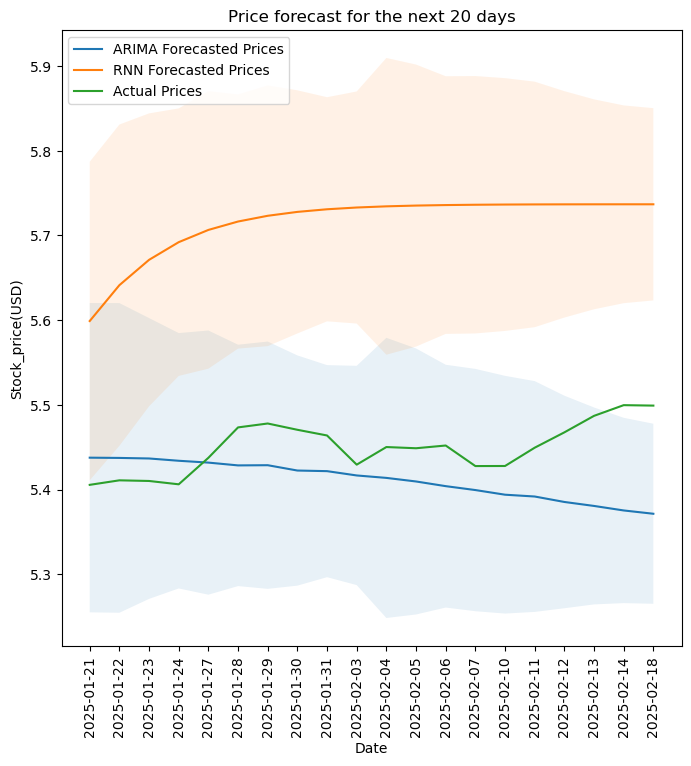

In [69]:
# Geometric Brownian Motion

def GBM(trend_pred, vol_pred, label = " "):
    stock_price_GBM = pd.DataFrame({'trend':trend_pred, 'vol': vol_pred})
    stock_price_GBM['high'] = stock_price_GBM.apply(lambda x: x[0] * np.exp(-0.5 * x[1] + np.sqrt(x[1]) ) , axis = 1)
    stock_price_GBM['low']  = stock_price_GBM.apply(lambda x: x[0] * np.exp(-0.5 * x[1] - np.sqrt(x[1]) ) , axis = 1)


    plt.plot(stock_price_GBM.index, stock_price_GBM['trend'], '-', label = label)
    plt.fill_between(stock_price_GBM.index, stock_price_GBM['high'], stock_price_GBM['low'], alpha = 0.1)
    plt.xlabel('Date')
    plt.ylabel('Stock_price(USD)')
    plt.title(f'Price forecast for the next {T} days')
    plt.xticks(stock_price_GBM.index, rotation='vertical')
    


plt.figure(figsize = (8,8))

GBM(stock_forecast.log_close_predicted_ARIMA, forecasts.iloc[:,0].T, label='ARIMA Forecasted Prices')
GBM( y_RNN_forecast[:,-1], forecasts.iloc[:,0].T , label='RNN Forecasted Prices')
plt.plot(stock_forecast.index ,stock_forecast.log_close, label = "Actual Prices")
plt.legend()

plt.show()



## Conclusion:

Taking into account the variances, it seems the actual data is inside the expeced (1$\sigma$ error) resion. But the result of the RNN forecasts highly depends on the metaparameters/architecture that are used.